# Keras VGG16 for CIFAR10 test
keras vgg16 CIFAR10 for cifar10 test.

In [60]:
import matplotlib.pyplot as plt
import os
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from data_utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import tensorflow as tf 
from keras import backend as k
import os
config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.1
config.gpu_options.allow_growth = True
k.tensorflow_backend.set_session(tf.Session(config=config))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
# get data
cifar10_data = CIFAR10Data()
x_train, y_train, x_test, y_test = cifar10_data.get_data(subtract_mean=True)

num_train = int(x_train.shape[0] * 0.8)
num_val = x_train.shape[0] - num_train
mask = list(range(num_train, num_train+num_val))
x_val = x_train[mask]
y_val = y_train[mask]

mask = list(range(num_train))
x_train = x_train[mask]
y_train = y_train[mask]
print(x_train.shape)

CIFAR10 Training data shape: (50000, 32, 32, 3)
CIFAR10 Training label shape (50000, 1)
CIFAR10 Test data shape (10000, 32, 32, 3)
CIFAR10 Test label shape (10000, 1)
(40000, 32, 32, 3)


In [62]:
from classifiers.vgg import VGGNet 

weight_decay = 5e-4
lr = 1e-1
num_classes = 10

vgg = VGGNet(classes=num_classes, 
             input_shape=x_train.shape[1:], 
             weight_decay=weight_decay, 
             conv_block_num=4,
             fc_layers=2,
             fc_units=512
             ) 

# sgd
opt = keras.optimizers.SGD(lr=lr, momentum=0.9, nesterov=False)
vgg.compile(loss='categorical_crossentropy', 
            optimizer=opt, 
            metrics=['accuracy'])
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv1-1 (Conv2D)             (None, 32, 32, 64)        1792      
_________________________________________________________________
bn1-1 (BatchNormalization)   (None, 32, 32, 64)        256       
_________________________________________________________________
relu1-1 (Activation)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv1-2 (Conv2D)             (None, 32, 32, 64)        36928     
_________________________________________________________________
bn1-2 (BatchNormalization)   (None, 32, 32, 64)        256       
_________________________________________________________________
relu1-2 (Activation)         (None, 32, 32, 64)        0         
__________

In [63]:
%%time
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
# fit data with data augmentation or not
data_augmentation = True


def lr_scheduler(epoch):
    return lr * (0.1 ** (epoch // 50))

reduce_lr = LearningRateScheduler(lr_scheduler)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                               patience=10, min_lr=1e-6, verbose=1)

batch_size = 128
epochs = 200

if data_augmentation:
    # datagen
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False, # randomly flip images
    ) 
    # (std, mean, and principal components if ZCA whitening is applied).
    # datagen.fit(x_train)
    print('train with data augmentation')
    history = vgg.fit_generator(generator=datagen.flow(x_train, y_train, batch_size=batch_size),
                                epochs=epochs,
                                callbacks=[reduce_lr],
                                validation_data=(x_val, y_val)
                                )
else:
    print('train without data augmentation')
    history = vgg.fit(x_train, y_train, 
                      batch_size=batch_size, epochs=epochs, 
                      callbacks=[reduce_lr],
                      validation_data=(x_val, y_val)
                      )

train with data augmentation
Epoch 1/200
313/313 [==============================] - 66s 210ms/step - loss: 5.7679 - acc: 0.1453 - val_loss: 10.4572 - val_acc: 0.1104
Epoch 2/200
313/313 [==============================] - 49s 157ms/step - loss: 4.1786 - acc: 0.2248 - val_loss: 3.9182 - val_acc: 0.1537
Epoch 3/200
313/313 [==============================] - 49s 156ms/step - loss: 3.1412 - acc: 0.3114 - val_loss: 2.8202 - val_acc: 0.2938
Epoch 4/200
313/313 [==============================] - 50s 159ms/step - loss: 2.3636 - acc: 0.3983 - val_loss: 2.1213 - val_acc: 0.4376
Epoch 5/200
313/313 [==============================] - 48s 153ms/step - loss: 1.9158 - acc: 0.4820 - val_loss: 1.7849 - val_acc: 0.5327
Epoch 6/200
313/313 [==============================] - 49s 156ms/step - loss: 1.6774 - acc: 0.5332 - val_loss: 1.5774 - val_acc: 0.5609
Epoch 7/200
313/313 [==============================] - 45s 143ms/step - loss: 1.4760 - acc: 0.6030 - val_loss: 1.4848 - val_acc: 0.6071
Epoch 8/200
313/31

313/313 [==============================] - 47s 150ms/step - loss: 0.5694 - acc: 0.9353 - val_loss: 0.7042 - val_acc: 0.8918
Epoch 61/200
313/313 [==============================] - 46s 147ms/step - loss: 0.5498 - acc: 0.9349 - val_loss: 0.7367 - val_acc: 0.8787
Epoch 62/200
313/313 [==============================] - 46s 147ms/step - loss: 0.5318 - acc: 0.9380 - val_loss: 0.6651 - val_acc: 0.8990
Epoch 63/200
313/313 [==============================] - 45s 143ms/step - loss: 0.5192 - acc: 0.9375 - val_loss: 0.6598 - val_acc: 0.8965
Epoch 64/200
313/313 [==============================] - 46s 146ms/step - loss: 0.5017 - acc: 0.9411 - val_loss: 0.7047 - val_acc: 0.8784
Epoch 65/200
313/313 [==============================] - 44s 140ms/step - loss: 0.4912 - acc: 0.9425 - val_loss: 0.7257 - val_acc: 0.8745
Epoch 66/200
313/313 [==============================] - 46s 146ms/step - loss: 0.4780 - acc: 0.9434 - val_loss: 0.6833 - val_acc: 0.8813
Epoch 67/200
313/313 [==============================] 

Epoch 120/200
313/313 [==============================] - 49s 156ms/step - loss: 0.2735 - acc: 0.9932 - val_loss: 0.5814 - val_acc: 0.9226
Epoch 121/200
313/313 [==============================] - 53s 168ms/step - loss: 0.2691 - acc: 0.9941 - val_loss: 0.5825 - val_acc: 0.9235
Epoch 122/200
313/313 [==============================] - 49s 157ms/step - loss: 0.2689 - acc: 0.9935 - val_loss: 0.5790 - val_acc: 0.9233
Epoch 123/200
313/313 [==============================] - 48s 154ms/step - loss: 0.2679 - acc: 0.9937 - val_loss: 0.5834 - val_acc: 0.9219
Epoch 124/200
313/313 [==============================] - 46s 148ms/step - loss: 0.2635 - acc: 0.9944 - val_loss: 0.5944 - val_acc: 0.9213
Epoch 125/200
313/313 [==============================] - 46s 148ms/step - loss: 0.2631 - acc: 0.9943 - val_loss: 0.5850 - val_acc: 0.9226
Epoch 126/200
313/313 [==============================] - 50s 161ms/step - loss: 0.2593 - acc: 0.9948 - val_loss: 0.5753 - val_acc: 0.9245
Epoch 127/200
313/313 [===========

313/313 [==============================] - 47s 149ms/step - loss: 0.2147 - acc: 0.9979 - val_loss: 0.5623 - val_acc: 0.9257
Epoch 180/200
313/313 [==============================] - 43s 138ms/step - loss: 0.2151 - acc: 0.9976 - val_loss: 0.5622 - val_acc: 0.9257
Epoch 181/200
313/313 [==============================] - 42s 134ms/step - loss: 0.2129 - acc: 0.9981 - val_loss: 0.5623 - val_acc: 0.9256
Epoch 182/200
313/313 [==============================] - 40s 129ms/step - loss: 0.2147 - acc: 0.9976 - val_loss: 0.5658 - val_acc: 0.9254
Epoch 183/200
313/313 [==============================] - 42s 134ms/step - loss: 0.2145 - acc: 0.9975 - val_loss: 0.5645 - val_acc: 0.9244
Epoch 184/200
313/313 [==============================] - 43s 137ms/step - loss: 0.2133 - acc: 0.9980 - val_loss: 0.5642 - val_acc: 0.9247
Epoch 185/200
313/313 [==============================] - 44s 140ms/step - loss: 0.2130 - acc: 0.9981 - val_loss: 0.5634 - val_acc: 0.9254
Epoch 186/200
313/313 [=========================

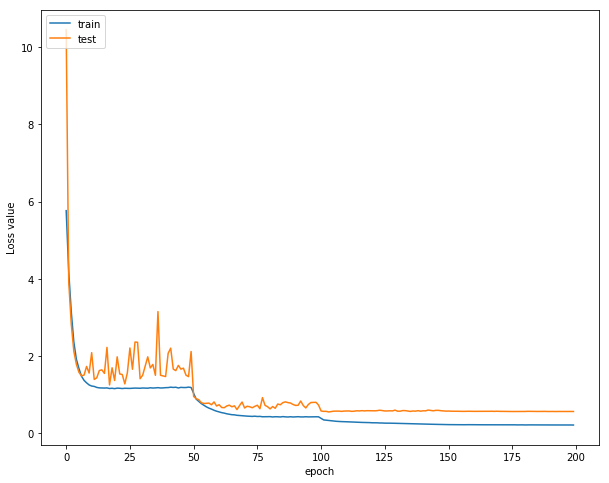

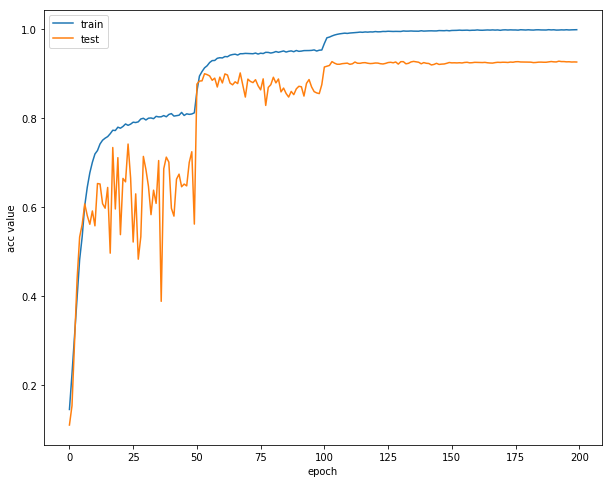

In [64]:
# plot loss and acc 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('Loss value')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('acc value')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [65]:
loss, acc = vgg.evaluate(x_test, y_test)
print('evaluate loss:%f acc:%f' % (loss, acc))

10000/10000 [==============================] - 6s 588us/step
evaluate loss:0.580091 acc:0.923200
